## Setup
As usual, we first import Mitsuba and Dr.Jit and set a variant that supports automatic differentiation.

In [21]:
%load_ext autoreload
%autoreload 2

import drjit as dr
import mitsuba as mi
mi.set_variant('cuda_ad_rgb', 'llvm_ad_rgb')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np


import matplotlib.pyplot as plt
from tlir import config as cf
from tlir import integrators
from tlir import training
from tlir import visualization
from tlir import camera_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example 1: Configuration and Setup
Create a configuration for the experiment. We'll use the new cached camera and rendering system.

In [22]:
# Example 1: Using the modular structure with cached cameras and images
print("=== Example 1: Quick Experiment with Cached Cameras ===\n")

# Create a configuration for a quick test
config = cf.create_config(
    "tlir_notebook_test",
    scene_name="lego",  # Options: 'lego', 'fog'
    num_stages=4,
    num_iterations_per_stage=1000,
    grid_init_res=16,
    render_res=256,
    spp=1,
    loss_type='l2',
    render_config=cf.RenderConfig(
        camera_center=[0.5, 0.5, 0.5],
        test_min_elevation=30.0,
        test_max_elevation=30.0,
        test_num_loops=1,
    )
)

# Validate the configuration
issues = cf.validate_config(config)
if issues:
    print("Configuration issues:", issues)
else:
    print("✓ Configuration is valid!")

print(f"\nExperiment: {config.experiment_name}")
print(f"Scene: {config.scene_name}")
print(f"Output directory: {config.output_dir}")
print(f"Stages: {config.num_stages}, Iterations per stage: {config.num_iterations_per_stage}")
print(f"Grid resolution: {config.grid_init_res}")
print(f"Integrator: {config.integrator_type}")

=== Example 1: Quick Experiment with Cached Cameras ===

✓ Configuration is valid!

Experiment: tlir_notebook_test
Scene: lego
Output directory: ./outputs/tlir_notebook_test_20251113_223815
Stages: 4, Iterations per stage: 1000
Grid resolution: 16
Integrator: rf_prb


## Example 2: Create and Cache Cameras and Images
Use the camera utilities to create random training views on the upper hemisphere and a smooth test trajectory. 
Images and poses are cached to `data/<scene_name>` so subsequent runs are fast.

In [23]:
# Example 2: Create or load cached cameras and images
print("=== Example 2: Creating/Loading Cached Cameras and Images ===\n")

# Create reference scene for rendering ground truth
scene_ref = training.create_scene_reference(config)
print(f"✓ Loaded reference scene: {config.scene_name}")

# Create or load cached cameras and images using render_config (RECOMMENDED)
# The render_config contains all rendering parameters in one place
cache_dir = f"./data/{config.scene_name}"

data = camera_utils.create_cached_cameras_and_images(
    scene=scene_ref,
    cache_dir=cache_dir,
    render_config=config.render_config,  # Uses config's render settings
    force_rerender=False  # Set to True to force re-rendering
)

print(f"\n✓ Training: {len(data['train_sensors'])} cameras")
print(f"  - Images: {len(data['train_images'])} rendered")
print(f"  - Masks: {len(data['train_masks'])} rendered")
print(f"  - Depths: {len(data['train_depths'])} rendered")
print(f"  - Normals: {len(data['train_normals'])} rendered")
print(f"\n✓ Test: {len(data['test_sensors'])} cameras")
print(f"  - Images: {len(data['test_images'])} rendered")
print(f"  - Masks: {len(data['test_masks'])} rendered")
print(f"  - Depths: {len(data['test_depths'])} rendered")
print(f"  - Normals: {len(data['test_normals'])} rendered")
print(f"\n✓ Image shape: {data['train_images'][0].shape}")
print(f"\nNote: All data saved as both NPY and PNG files in {cache_dir}")

=== Example 2: Creating/Loading Cached Cameras and Images ===

✓ Loaded reference scene: lego
Loading training data from cache...
Loaded 100 poses from ./data/lego/train_poses.npy
Loaded 100 images from ./data/lego/train/images
Loaded 100 images from ./data/lego/train/masks
Loaded 100 images from ./data/lego/train/depths
Loaded 100 images from ./data/lego/train/normals
Loading test data from cache...
Loaded 100 poses from ./data/lego/test_poses.npy
Loaded 100 images from ./data/lego/test/images
Loaded 100 images from ./data/lego/test/masks
Loaded 100 images from ./data/lego/test/depths
Loaded 100 images from ./data/lego/test/normals

✓ Training: 100 cameras
  - Images: 100 rendered
  - Masks: 100 rendered
  - Depths: 100 rendered
  - Normals: 100 rendered

✓ Test: 100 cameras
  - Images: 100 rendered
  - Masks: 100 rendered
  - Depths: 100 rendered
  - Normals: 100 rendered

✓ Image shape: (256, 256, 4)

Note: All data saved as both NPY and PNG files in ./data/lego


## Visualize Training and Test Images

Training views (uniformly distributed on sphere, elevation 10-80°):


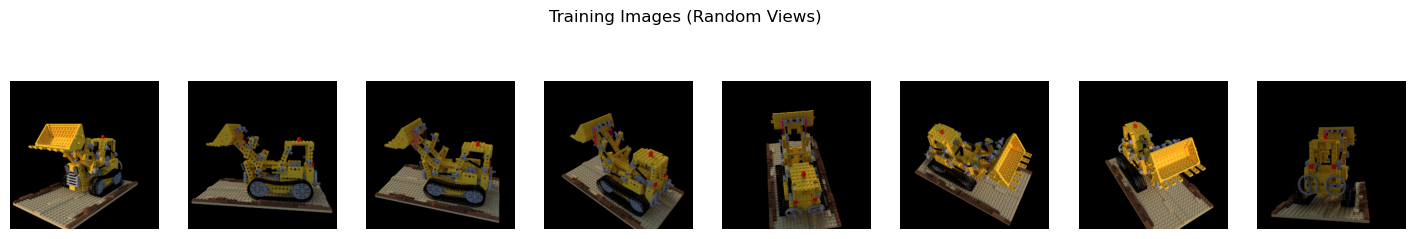


Test spiral trajectory (elevation at 30° during rotation):


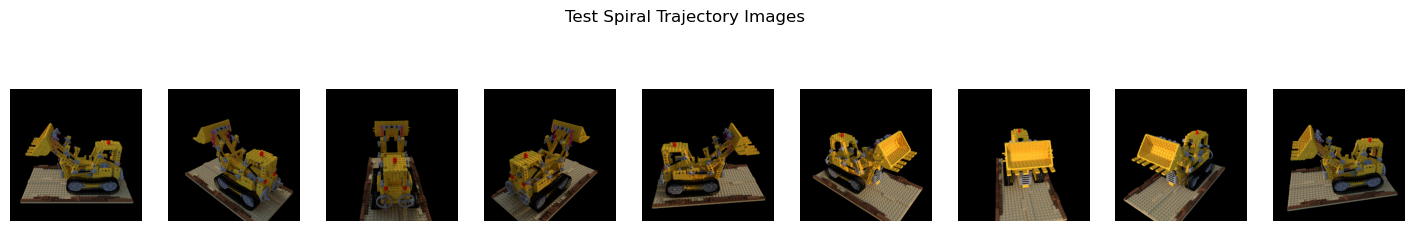

In [24]:
# Visualize some training images
print("Training views (uniformly distributed on sphere, elevation 10-80°):")
visualization.plot_list(data['train_images'][:8], 'Training Images (Random Views)')

# Visualize some test trajectory images
print("\nTest spiral trajectory (elevation at 30° during rotation):")
visualization.plot_list(data['test_images'][::12], 'Test Spiral Trajectory Images')

## Visualize Depths, Normals, and Masks
The dataset now includes depth maps (with turbo colormap), surface normals (XYZ→RGB), and object masks.

Depth range for visualization: [0.8924, 1.8189]

=== Training Data Visualization ===

1. RGB Images:


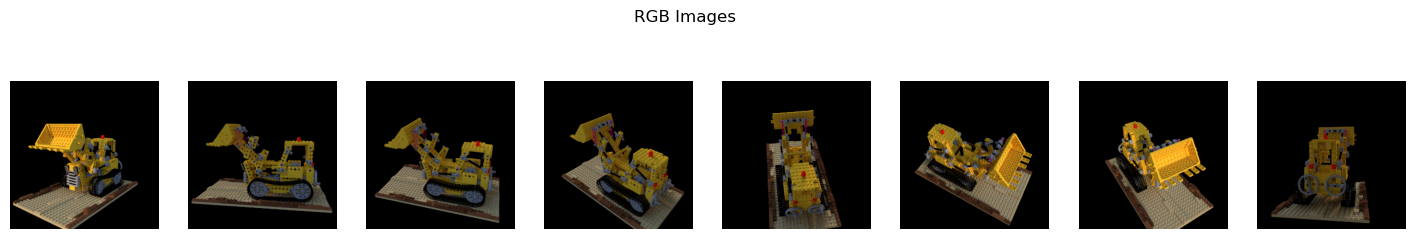


2. Depth Maps (Turbo Colormap):


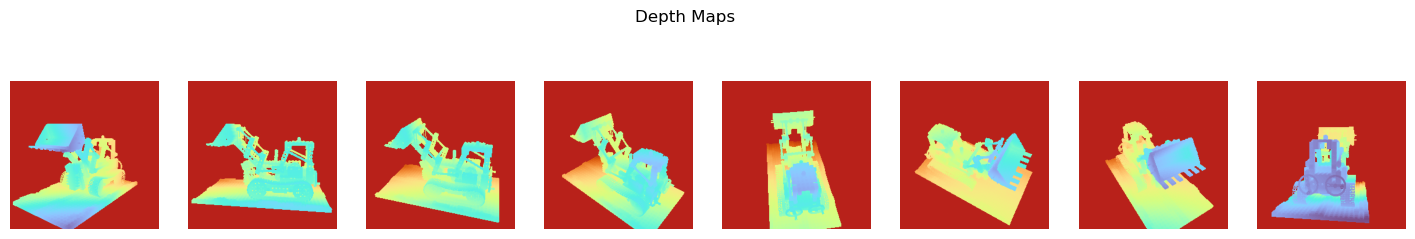


3. Surface Normals (XYZ→RGB):


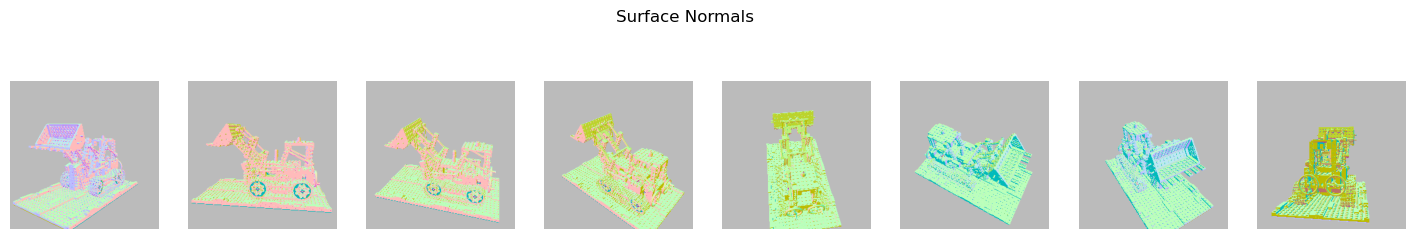


4. Object Masks:


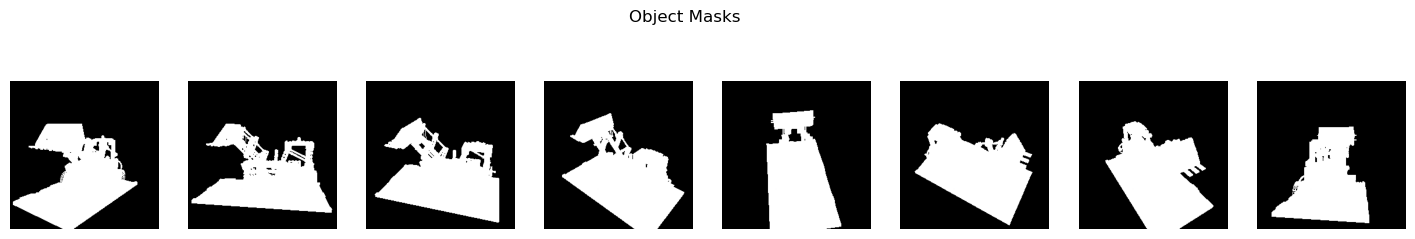

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3395383].


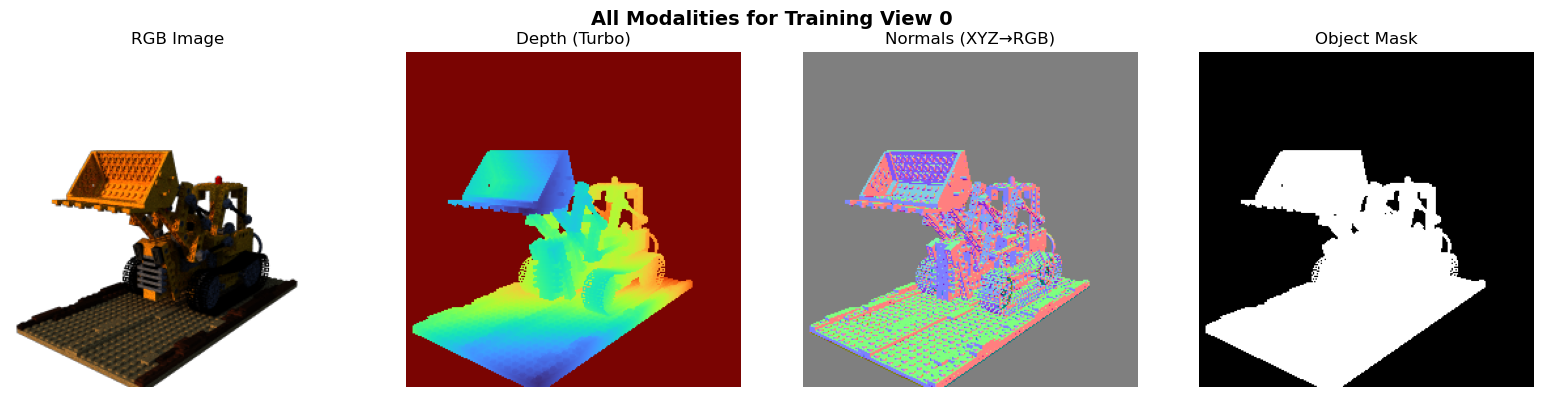

In [25]:
import numpy as np

# Helper function to visualize depth with turbo colormap
def visualize_depth(depth, vmin=None, vmax=None):
    """Convert depth to RGB using turbo colormap."""
    # Filter out invalid depths
    valid_depth = depth[depth < 1e9]
    if vmin is None:
        vmin = np.min(valid_depth) if len(valid_depth) > 0 else 0.0
    if vmax is None:
        vmax = np.max(valid_depth) if len(valid_depth) > 0 else 1.0
    
    # Normalize
    depth_norm = (depth - vmin) / (vmax - vmin + 1e-8)
    depth_norm = np.clip(depth_norm, 0.0, 1.0)
    
    # Apply turbo colormap
    try:
        import matplotlib.pyplot as plt
        colormap = plt.cm.turbo
        rgb = colormap(depth_norm)[:, :, :3]
    except:
        # Fallback: simple jet-like colormap
        r = np.clip(4 * depth_norm - 1.5, 0, 1)
        g = np.clip(1 - np.abs(4 * depth_norm - 2), 0, 1)
        b = np.clip(2.5 - 4 * depth_norm, 0, 1)
        rgb = np.stack([r, g, b], axis=-1)
    
    return rgb

# Helper function to visualize normals
def visualize_normals(normals):
    """Convert normals from [-1, 1] to RGB [0, 1]."""
    return (normals + 1.0) / 2.0

# Compute global depth range for consistent visualization
train_valid_depths = []
for depth in data['train_depths'][:8]:
    valid = depth[depth < 1e9]
    if len(valid) > 0:
        train_valid_depths.extend(valid.flatten().tolist())
depth_vmin = np.min(train_valid_depths)
depth_vmax = np.max(train_valid_depths)
print(f"Depth range for visualization: [{depth_vmin:.4f}, {depth_vmax:.4f}]")

# Visualize training data: RGB, Depth, Normals, Masks
print("\n=== Training Data Visualization ===")

print("\n1. RGB Images:")
visualization.plot_list(data['train_images'][:8], 'RGB Images')

print("\n2. Depth Maps (Turbo Colormap):")
depth_vis = [visualize_depth(d, depth_vmin, depth_vmax) for d in data['train_depths'][:8]]
visualization.plot_list(depth_vis, 'Depth Maps')

print("\n3. Surface Normals (XYZ→RGB):")
normal_vis = [visualize_normals(n) for n in data['train_normals'][:8]]
visualization.plot_list(normal_vis, 'Surface Normals')

print("\n4. Object Masks:")
# Convert single-channel masks to RGB for visualization
mask_vis = [np.repeat(m, 3, axis=-1) if m.shape[-1] == 1 else m for m in data['train_masks'][:8]]
visualization.plot_list(mask_vis, 'Object Masks')

# Show one comparison (all modalities for same view)
idx = 0
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(data['train_images'][idx])
axes[0].set_title('RGB Image', fontsize=12)
axes[0].axis('off')

axes[1].imshow(visualize_depth(data['train_depths'][idx], depth_vmin, depth_vmax))
axes[1].set_title('Depth (Turbo)', fontsize=12)
axes[1].axis('off')

axes[2].imshow(visualize_normals(data['train_normals'][idx]))
axes[2].set_title('Normals (XYZ→RGB)', fontsize=12)
axes[2].axis('off')

mask_rgb = np.repeat(data['train_masks'][idx], 3, axis=-1) if data['train_masks'][idx].shape[-1] == 1 else data['train_masks'][idx]
axes[3].imshow(mask_rgb)
axes[3].set_title('Object Mask', fontsize=12)
axes[3].axis('off')

plt.suptitle(f'All Modalities for Training View {idx}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Example 3: Train Radiance Field
Train on the random training views.

In [26]:
# Example 3: Run training using cached data
print("=== Example 3: Training with Cached Data ===\n")

# Create trainable scene
scene = training.create_scene(config.integrator_type)
print(f"✓ Created trainable scene with integrator: {config.integrator_type}")

# Set up logger
logger = visualization.TrainingLogger()

# Create training config
train_config = training.TrainingConfig(
    num_stages=config.num_stages,
    num_iterations_per_stage=config.num_iterations_per_stage,
    learning_rate=config.learning_rate,
    grid_init_res=config.grid_init_res,
    sh_degree=config.sh_degree,
    use_relu=config.use_relu,
    max_initial_density=config.max_initial_density,
    spp=config.spp,
    loss_type=config.loss_type,
    enable_upsampling=config.enable_upsampling,
    gt_noise_std=0.0,  # No noise augmentation (default)
    gt_noise_use_mask=True,  # Use masks if noise is enabled
    stochastic_preconditioning_starting_alpha=0.0,  # No SPN (default)
    stochastic_preconditioning_iterations=-1
)

print(f"\nTraining on {len(data['train_sensors'])} views...")
print(f"Heldout test: {len(data['test_sensors'])} views\n")

# Train
# Note: ref_masks can be passed from the dataset (data['train_masks'])
results = training.train_radiance_field(
    scene=scene,
    sensors=data['train_sensors'],
    ref_images=data['train_images'],
    config=train_config,
    ref_masks=data['train_masks'],  # Pass masks from dataset
    progress_callback=logger.log_progress
)

print(f"\n✓ Training completed!")
print(f"Total iterations: {len(results['losses'])}")
print(f"Initial loss: {results['losses'][0]:.6f}")
print(f"Final loss: {results['losses'][-1]:.6f}")
print(f"Improvement: {results['losses'][0] - results['losses'][-1]:.6f}")

=== Example 3: Training with Cached Data ===

✓ Created trainable scene with integrator: rf_prb

Training on 100 views...
Heldout test: 100 views

Stage 01, feature voxel grids resolution -> 16
[22:38:28] Stage 01, Iteration 01: Loss = 0.004167045466601849
[22:38:28] Stage 01, Iteration 02: Loss = 0.013535955920815468
[22:38:28] Stage 01, Iteration 03: Loss = 0.0014603089075535536
[22:38:28] Stage 01, Iteration 04: Loss = 0.004840632900595665
[22:38:28] Stage 01, Iteration 05: Loss = 0.0017418352654203773
[22:38:28] Stage 01, Iteration 06: Loss = 0.0015047307824715972
[22:38:28] Stage 01, Iteration 07: Loss = 0.001009795698337257
[22:38:28] Stage 01, Iteration 08: Loss = 0.001797477132640779
[22:38:28] Stage 01, Iteration 09: Loss = 0.015518016181886196
[22:38:28] Stage 01, Iteration 10: Loss = 0.0021522766910493374
[22:38:28] Stage 01, Iteration 11: Loss = 0.003154090605676174
[22:38:28] Stage 01, Iteration 12: Loss = 0.006237888243049383
[22:38:28] Stage 01, Iteration 13: Loss = 0.00

## Example 4: Evaluate on Test Trajectory
Render the trained radiance field on the heldout test trajectory and compute metrics.

In [27]:
# Example 4: Evaluate on heldout test trajectory
print("=== Example 4: Evaluation on Test Trajectory ===\n")

# Get final parameters
params = results['final_params']

# Get integrator from scene
integrator = scene.integrator()

# Create sampler
sampler_test = mi.load_dict({'type': 'independent'})

# Create output directories for test renderings
test_output_dir = os.path.join(config.output_dir, "test_renderings")
depth_output_dir = os.path.join(config.output_dir, "test_renderings", "depth")
os.makedirs(test_output_dir, exist_ok=True)
os.makedirs(depth_output_dir, exist_ok=True)
print(f"Saving test renderings to {test_output_dir}")
print(f"Saving depth renderings to {depth_output_dir}")

# First pass: collect depth statistics for consistent colormapping
print(f"\nCollecting depth statistics from {len(data['test_sensors'][::12])} test views...")
all_valid_depths = []

for i, sensor in enumerate(data['test_sensors'][::12]):
    rgb, aovs = integrator.render_camera(sensor, sampler_test, scene, spp=1)
    
    if len(aovs) > 0:
        depth_np = np.array(aovs[0])
        valid_depths = depth_np[depth_np < 1e9]
        if len(valid_depths) > 0:
            all_valid_depths.extend(valid_depths.flatten().tolist())

# Compute global depth range
if len(all_valid_depths) > 0:
    depth_vmin = float(np.min(all_valid_depths))
    depth_vmax = float(np.max(all_valid_depths))
    print(f"Depth range: [{depth_vmin:.4f}, {depth_vmax:.4f}]")
else:
    depth_vmin = 0.0
    depth_vmax = 1.0
    print("Warning: No valid depths found, using default range [0, 1]")

# Second pass: render and save both RGB and depth with consistent colormap
print(f"\nRendering {len(data['test_sensors'][::12])} test views (RGB + Depth)...")
test_loss = 0.0

for i, sensor in enumerate(data['test_sensors'][::12]):
    # Render using render_camera
    rgb, aovs = integrator.render_camera(sensor, sampler_test, scene, spp=1)
    
    # Convert RGB to numpy
    rendered = np.array(rgb)
    
    # Save RGB image
    img_path = os.path.join(test_output_dir, f"test_rendered_{i:04d}.png")
    img_8bit = np.clip(rendered[:, :, :3] * 255.0, 0, 255).astype(np.uint8)
    mi.Bitmap(img_8bit).write(img_path)
    
    # Process and save depth if available
    if len(aovs) > 0:
        depth_np = np.array(aovs[0])
        
        # Save raw depth as NPY
        depth_npy_path = os.path.join(depth_output_dir, f"depth_{i:04d}.npy")
        np.save(depth_npy_path, depth_np)
        
        # Apply turbo colormap and save as PNG
        depth_vis = visualize_depth(depth_np, depth_vmin, depth_vmax)
        depth_png_path = os.path.join(depth_output_dir, f"depth_{i:04d}.png")
        depth_vis_uint8 = (depth_vis * 255).astype(np.uint8)
        mi.Bitmap(depth_vis_uint8).write(depth_png_path)
    
    print(f"  Rendered and saved {i+1}/{len(data['test_sensors'][::12])} (RGB + Depth)", end='\r')

print(f"\n✓ Rendered all test views and saved to {test_output_dir}")
print(f"✓ Saved {len(data['test_sensors'][::12])} RGB images (PNG)")
print(f"✓ Saved {len(data['test_sensors'][::12])} depth images (NPY + PNG with turbo colormap)")

print(f"\nMetrics:")
print(f"  Training loss (final): {results['losses'][-1]:.6f}")

=== Example 4: Evaluation on Test Trajectory ===

Saving test renderings to ./outputs/tlir_notebook_test_20251113_223815/test_renderings
Saving depth renderings to ./outputs/tlir_notebook_test_20251113_223815/test_renderings/depth

Depth range: [0.0000, 1.5109]

Rendering 9 test views (RGB + Depth)...
  Rendered and saved 9/9 (RGB + Depth)
✓ Rendered all test views and saved to ./outputs/tlir_notebook_test_20251113_223815/test_renderings
✓ Saved 9 RGB images (PNG)
✓ Saved 9 depth images (NPY + PNG with turbo colormap)

Metrics:
  Training loss (final): 0.000978


## Visualize Results

In [ ]:
# Visualize results
print("=== Visualization ===\n")

# Load a few test images from disk for comparison
indices = list(range(0, len(data['test_sensors']), 6))
print(f"Comparing {len(indices)} frames from test trajectory:\n")

# Load last couple rendered images from disk
gt_samples = []
rendered_samples = []
for i in indices[-2:]:
    gt_samples.append(data['test_images'][i])
    
    # Load rendered image from disk
    rendered_path = os.path.join(test_output_dir, f"test_rendered_{i:04d}.png")
    if os.path.exists(rendered_path):
        rendered = plt.imread(rendered_path)
        rendered_samples.append(rendered)

if len(gt_samples) > 0:
    visualization.plot_list(gt_samples, 'Ground Truth (Test Trajectory)')

if len(rendered_samples) > 0:
    visualization.plot_list(rendered_samples, 'Rendered (Test Trajectory)')

# Plot loss curve
plt.figure(figsize=(10, 4))
plt.plot(results['losses'], linewidth=2)
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Curve', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Example 5 (Optional): Advanced Features
Try GT noise augmentation and/or stochastic preconditioning

In [ ]:
# Example 5: Training with advanced features
print("=== Example 5: Advanced Features ===\n")

# Create a new scene for this experiment
scene_advanced = training.create_scene(config.integrator_type)

# Calculate total iterations for SPN decay schedule
total_iterations = config.num_stages * config.num_iterations_per_stage

# Create config with advanced features
train_config_advanced = training.TrainingConfig(
    num_stages=config.num_stages,
    num_iterations_per_stage=config.num_iterations_per_stage,
    learning_rate=config.learning_rate,
    grid_init_res=config.grid_init_res,
    sh_degree=config.sh_degree,
    use_relu=config.use_relu,
    max_initial_density=config.max_initial_density,
    spp=config.spp,
    loss_type=config.loss_type,
    enable_upsampling=False,  # Disable multi-res when using SPN
    gt_noise_std=0.02,  # GT image noise augmentation (2%)
    gt_noise_use_mask=True,  # Apply noise only to background (default)
    stochastic_preconditioning_starting_alpha=0.01,  # SPN starting scale
    stochastic_preconditioning_iterations=total_iterations // 2  # Decay over first half
)

print("Advanced features enabled:")
print(f"  ✓ GT noise augmentation: std={train_config_advanced.gt_noise_std}, masked={train_config_advanced.gt_noise_use_mask}")
print(f"  ✓ Stochastic preconditioning: alpha={train_config_advanced.stochastic_preconditioning_starting_alpha}, decay_iters={train_config_advanced.stochastic_preconditioning_iterations}")
print(f"  ✓ Multi-resolution training: disabled (using SPN as alternative)")
print()

# Train with advanced features
# Pass ref_masks from the dataset (masks are already rendered and cached)
results_advanced = training.train_radiance_field(
    scene=scene_advanced,
    sensors=data['train_sensors'],
    ref_images=data['train_images'],
    config=train_config_advanced,
    ref_masks=data['train_masks']  # Use cached masks from dataset
)

print(f"\n✓ Advanced training completed!")
print(f"Final loss: {results_advanced['losses'][-1]:.6f}")
print(f"Baseline final loss: {results['losses'][-1]:.6f}")
print(f"Difference: {results['losses'][-1] - results_advanced['losses'][-1]:.6f}")

## Example 6 (Optional): Ratio Tracking Integrator
Train using ratio tracking for comparison

In [ ]:
# Example 6: Using ratio tracking integrator
print("=== Example 6: Ratio Tracking Integrator ===\n")

# Create configuration for ratio tracking
config_rt = cf.create_ratio_tracking_config("notebook_rt_test")
config_rt.num_stages = 4
config_rt.num_iterations_per_stage = 50
config_rt.render_res = config.render_res
config_rt.spp = 64
config_rt.loss_type = 'l2'

print(f"Ratio tracking config:")
print(f"  Initial majorant: {config_rt.initial_majorant}")
print(f"  Stop gradient on density: {config_rt.stopgrad_density}")
print()

# Create scene with ratio tracking integrator
scene_rt = training.create_scene('rf_prb_rt')

# Create training config
train_config_rt = training.TrainingConfig(
    num_stages=config_rt.num_stages,
    num_iterations_per_stage=config_rt.num_iterations_per_stage,
    learning_rate=config_rt.learning_rate,
    grid_init_res=config_rt.grid_init_res,
    sh_degree=config_rt.sh_degree,
    use_relu=config_rt.use_relu,
    max_initial_density=config_rt.max_initial_density,
    spp=config_rt.spp,
    loss_type=config_rt.loss_type,
    enable_upsampling=config_rt.enable_upsampling
)

# Train with ratio tracking
print("Training with ratio tracking...\n")
results_rt = training.train_radiance_field(
    scene=scene_rt,
    sensors=data['train_sensors'],
    ref_images=data['train_images'],
    config=train_config_rt,
    ref_masks=data['train_masks']  # Pass masks from dataset
)

print(f"\n✓ Ratio tracking training completed!")
print(f"Final loss: {results_rt['losses'][-1]:.6f}")

# Render and save comparison images
print("\nRendering comparison images...")
integrator_rt = scene_rt.integrator()
sampler_rt = mi.load_dict({'type': 'independent'})

# Create output directory
rt_output_dir = os.path.join(config_rt.output_dir, "rt_comparisons")
os.makedirs(rt_output_dir, exist_ok=True)

# Render every 6th frame and save to disk
comparison_indices = list(range(0, len(data['test_sensors']), 6))
for idx, i in enumerate(comparison_indices):
    sensor = data['test_sensors'][i]
    rgb, aovs = integrator_rt.render_camera(sensor, sampler_rt, scene_rt, spp=256)
    
    # Save rendered image
    rgb_np = np.array(rgb)
    rgb_uint8 = (np.clip(rgb_np, 0, 1) * 255).astype(np.uint8)
    output_path = os.path.join(rt_output_dir, f"rt_rendered_{i:04d}.png")
    mi.Bitmap(rgb_uint8).write(output_path)
    
    print(f"  Rendered {idx+1}/{len(comparison_indices)}", end='\r')

print(f"\n✓ Saved ratio tracking results to {rt_output_dir}")

# Load and visualize ground truth vs ratio tracking (load from disk)
print("\nLoading images for visualization...")
gt_images = [data['test_images'][i] for i in comparison_indices]
rt_images = []
for i in comparison_indices:
    img_path = os.path.join(rt_output_dir, f"rt_rendered_{i:04d}.png")
    if os.path.exists(img_path):
        rt_images.append(plt.imread(img_path))

visualization.plot_list(gt_images, 'Ground Truth')
if len(rt_images) > 0:
    visualization.plot_list(rt_images, 'Ratio Tracking Results')

## Summary

This notebook demonstrates:

1. **Cached Camera System with Multi-Modal Rendering**:
   - Training views: **Uniformly distributed** on sphere surface (3D normal sampling + reflection)
   - Test views: **Spiral trajectory** with changing elevation
   - **All modalities rendered and cached**:
     - ✅ RGB images (with proper lighting)
     - ✅ Depth maps (NPY + PNG with turbo colormap)
     - ✅ Surface normals (NPY + PNG with XYZ→RGB mapping)
     - ✅ Object masks (for noise augmentation)
   - Single-pass rendering for efficiency
   - Automatic caching to `data/<scene_name>` (fast subsequent runs)
   - All data saved as both NPY (raw values) and PNG (visualization)

2. **Baseline Training**: Standard radiance field training
   - Multi-resolution grid upsampling
   - Progressive refinement over stages
   - Uses cached masks from dataset

3. **Memory-Efficient Test Rendering**:
   - **Images saved as rendered** - no accumulation of 100+ images in memory
   - Test renderings saved to `outputs/<experiment>/test_renderings/`
   - Depth + RGB saved to `outputs/<experiment>/experiments/`
   - Visualizations load from disk only for display
   - Two-pass depth rendering: collect statistics, then save with consistent colormap

4. **Advanced Features** (optional):
   - GT noise augmentation with **masked noise** (background only)
   - Stochastic preconditioning: Alternative to multi-resolution
   - Both use pre-rendered masks from dataset

5. **Multiple Integrators**: Regular ray marching vs ratio tracking

### Key Improvements:
- ✅ **Unified ray sampling**: Image-based and ray-based modes now identical except for ray sampling strategy
- ✅ **Uniform sampling** on sphere surface (not biased toward poles)
- ✅ **Multi-modal dataset**: RGB, depth, normals, masks all rendered together
- ✅ **Efficient rendering**: Single-pass extraction of all modalities
- ✅ Proper train/test split with diverse views
- ✅ **Spiral test trajectory** covers multiple elevations smoothly
- ✅ Fast iterations with caching
- ✅ **PNG visualization** for all data types
- ✅ Modular and extensible structure
- ✅ **Memory efficient**: Stream-to-disk rendering for test views
- ✅ **Vectorized ray generation**: No Python loops, pure DrJit operations
- ✅ **No unnecessary conversions**: Direct Mitsuba type reshaping

### Camera Sampling Details:
- **Training**: 3D normal distribution → normalize → reflect (for hemisphere) → uniform on surface
- **Test**: Parametric spiral `(theta, elevation) = (t * 2π * num_loops, constant or varying)`
- **Flexibility**: Can filter by elevation range via `min/max_elevation` parameters

### Dataset Structure:
```
data/<scene_name>/
├── train_poses.npy
├── test_poses.npy
├── train/
│   ├── images/ (RGB: *.npy, *.png)
│   ├── depths/ (depth: *.npy, *.png with turbo)
│   ├── normals/ (normals: *.npy, *.png with XYZ→RGB)
│   └── masks/ (masks: *.npy, *.png grayscale)
└── test/ (same structure)
```

### Output Structure (per experiment):
```
outputs/<experiment_name>/
├── test_renderings/     (rendered test views)
│   └── test_rendered_*.png
├── experiments/
│   ├── rgb/            (RGB from trained model)
│   │   └── rgb_*.png
│   └── depth/          (depth maps from trained model)
│       ├── depth_*.npy (raw values)
│       └── depth_*.png (turbo colormap)
└── rt_comparisons/     (ratio tracking results, if applicable)
    └── rt_rendered_*.png
```

### Rendering Workflow:
1. **Training**: Load cached dataset (100 views in memory for sampling)
2. **Test Evaluation**: Render → Save → Compute Loss → Next (no accumulation)
3. **Depth Rendering**: 
   - Pass 1: Render → Save NPY + RGB → Collect depth stats
   - Pass 2: Load NPY → Apply colormap → Save PNG
4. **Visualization**: Load few samples from disk for display

### Visualization Features:
- RGB images with proper lighting
- Depth maps with turbo colormap (consistent normalization)
- Surface normals with XYZ→RGB mapping
- Object masks for noise augmentation
- Side-by-side comparison of all modalities
- Memory-efficient: only load what's displayed